# Time Series Analysis

1. Read BARPA and ERA
2. Select locations for time series
3. plot summary time series
    - FFDI, DWI, FFDI_F
5. look for trends


In [1]:
from glob import glob
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import importlib,warnings


## Put us in the right repo for local relative pathing
import os
__repo__="/g/data/en0/jwg574/repos/simple_fire_metric/"
os.chdir(__repo__)
import plotting, fio


In [2]:
from dask.distributed import Client
client = Client()
#display(client.proxy)
print(client.dashboard_link)

/proxy/8787/status


## GCMs
- evaluation/historical only
    - "ECMWF-ERA5",
    - "MPI-M-MPI-ESM1-2-HR", 
- with ssp projections:
    - "CMCC-CMCC-ESM2", # Just ssp370, and hisorical
    - "CSIRO-ACCESS-ESM1-5", # both ssp370,ssp126, others?
- not yet looked at 
    - "CSIRO-ARCCSS-ACCESS-CM2",
    - "EC-Earth-Consortium-EC-Earth3",
    - "NCAR-CESM2","CSIRO-ACCESS-ESM1-5",
    - "NCC-NorESM2-MM",

## experiments

- "evaluation": 1979-2020
- "historical": 1960-2014
- "ssp126": 2015-2100
- "ssp370": 2015-2100

# 1 Read Data

- Time series: N_series = N_models x N_metrics x N_locations
    - Models: ERA5, several BARPA instances,
    - Metrics: FFDI, FFDI_F, and DWI_V
    - Locations: melb, adelaide, sydney, darwin
        - Darwin has big mismatch between ERA5 and BARPA
            - could be due to grid size (ERA5 is .25, BARPa is .15) giving more ocean or inland area
            - need to add driving metrics to timeseries
    
  

In [3]:
importlib.reload(fio)

## Get index matching location
latlons=fio.TIMESERIES_LOCATIONS


## Check Resolution
# rename lon,lat to match BARPA
ds_ERA5 = fio.ERA5_read_dailymaximums().rename({'longitude':'lon','latitude':'lat'})
ds_cmcc = fio.BARPA_read_intermediate_years("*",experiment='ssp370')


for ds,name in zip([ds_ERA5, ds_cmcc],['era','barpa']):
    print("=======  %s ========"%name)
    
    for (place,deets) in latlons.items():
        lat,lon = deets['latlon']
        abslat = np.abs(ds.lat-lat)
        abslon = np.abs(ds.lon-lon)
        c = np.maximum(abslon, abslat)
        ([xloc], [yloc]) = np.where(c == np.min(c))
    
        print(place,lat,lon)
        print("    ilat, ilon: %d, %d"%(yloc,xloc))
        print("    %s lat,lon:"%name, ds.lat.values[yloc],ds.lon.values[xloc])
    


print("=============== resolution check ============")
print("ERA5: ",ds_ERA5.dims,)
print("    DX:", ds_ERA5.lon.values[1]-ds_ERA5.lon.values[0])
print("    DY:", ds_ERA5.lat.values[1]-ds_ERA5.lat.values[0])
print("BARPA: ", ds_cmcc.dims,) 
print("    DX: %.4f"%(ds_cmcc.lon.values[1]-ds_cmcc.lon.values[0]))
print("    DY: %.4f"%(ds_cmcc.lat.values[1]-ds_cmcc.lat.values[0]))

    

INFO: Reading 86 BARPA dailymax files matching year *
=======  era ========
Melb -37.6722 144.8503
    ilat, ilon: 115, 135
    era lat,lon: -37.75 144.75
Adel -34.9063 138.8397
    ilat, ilon: 104, 111
    era lat,lon: -35.0 138.75
Sydn -33.8 150.7
    ilat, ilon: 99, 159
    era lat,lon: -33.75 150.75
Darw -12.464 130.85
    ilat, ilon: 14, 79
    era lat,lon: -12.5 130.75
Dar2 -12.71 131.1
    ilat, ilon: 15, 80
    era lat,lon: -12.75 131.0
=======  barpa ========
Melb -37.6722 144.8503
    ilat, ilon: 103, 368
    barpa lat,lon: -37.662 144.89149
Adel -34.9063 138.8397
    ilat, ilon: 121, 329
    barpa lat,lon: -34.881 138.866
Sydn -33.8 150.7
    ilat, ilon: 128, 406
    barpa lat,lon: -33.7995 150.7625
Darw -12.464 130.85
    ilat, ilon: 266, 277
    barpa lat,lon: -12.4785 130.832
Dar2 -12.71 131.1
    ilat, ilon: 265, 279
    barpa lat,lon: -12.633 131.14099
=============== resolution check ============
ERA5:  Frozen({'lon': 177, 'lat': 157, 'time': 24472})
    DX: 0.25
    D

In [5]:
%%time
importlib.reload(fio)
## takes ~35 minutes for new creation
## Uses up to 4 GB RAM
ts_melb = fio.get_time_series("Melb",force_renew=False,verbose=True)

INFO: data/timeseries_Melb.pickle found, reading data
CPU times: user 29.2 ms, sys: 23 ms, total: 52.2 ms
Wall time: 99.6 ms


In [6]:
ts_melb.keys()

dict_keys(['Melb_FFDI_CMCC_hist', 'Melb_FFDI_CMCC_370', 'Melb_FFDI_CSIRO_ESM_370', 'Melb_FFDI_CSIRO_ESM_126', 'Melb_FFDI_ERA5', 'Melb_DWI_V_CMCC_hist', 'Melb_DWI_V_CMCC_370', 'Melb_DWI_V_CSIRO_ESM_370', 'Melb_DWI_V_CSIRO_ESM_126', 'Melb_DWI_V_ERA5', 'Melb_FFDI_F_CMCC_hist', 'Melb_FFDI_F_CMCC_370', 'Melb_FFDI_F_CSIRO_ESM_370', 'Melb_FFDI_F_CSIRO_ESM_126', 'Melb_FFDI_F_ERA5'])

In [2]:
%%time
# get all the other sites
ts_melb = fio.get_time_series("Melb")
ts_adel = fio.get_time_series('Adel') # should already be made
ts_darw = fio.get_time_series('Darw')
ts_sydn = fio.get_time_series('Sydn')
ts_dar2 = fio.get_time_series('Dar2')

INFO: data/timeseries_Melb.pickle found, reading data
INFO: data/timeseries_Adel.pickle found, reading data
INFO: data/timeseries_Darw.pickle found, reading data
INFO: data/timeseries_Sydn.pickle found, reading data
INFO: data/timeseries_Dar2.pickle found, reading data
CPU times: user 60.5 ms, sys: 60 ms, total: 121 ms
Wall time: 454 ms


# 2. Show some time series for Locations

1. Yearly Maximum timeseries
2. Yearly 90th pctile
3. Mean seasonality (pre 2020, 2020-2080, post 2080)
4. Monthly time series (time series just for Jan, Feb, ..., independently) to see change in seasonality


In [3]:
#ts_places
from pylab import rcParams
import warnings # want to ignore calendar conversion warnings
from datetime import datetime

## maximum yearly

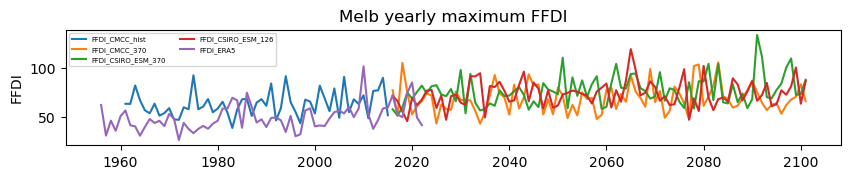

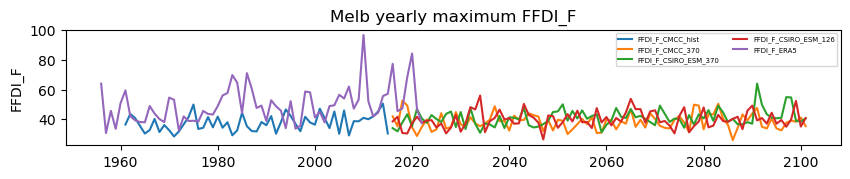

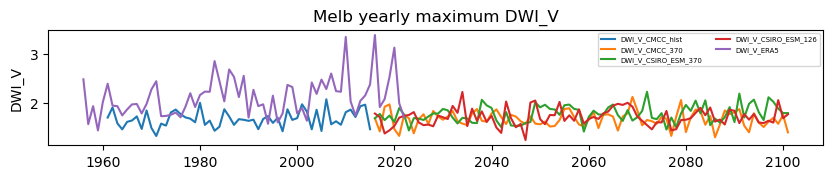

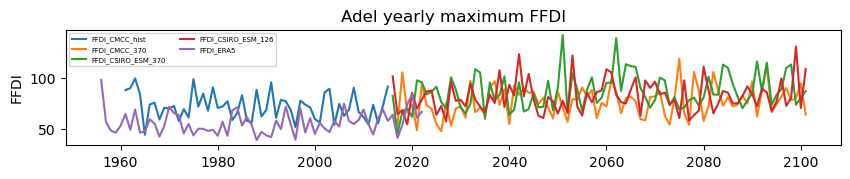

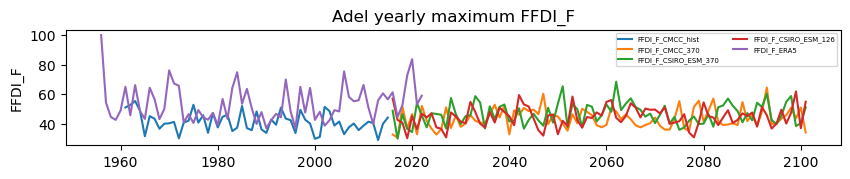

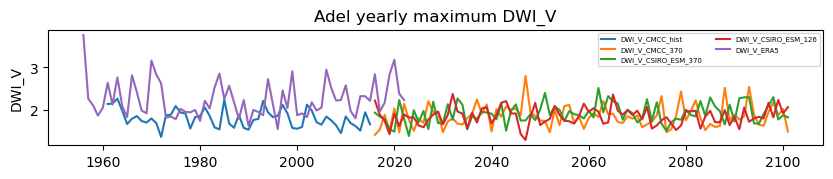

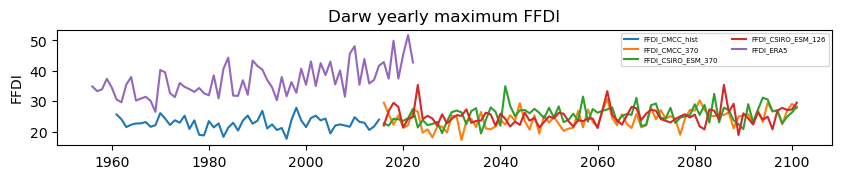

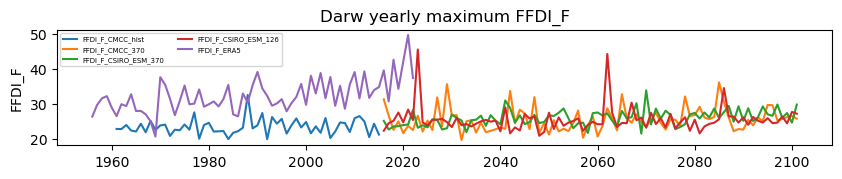

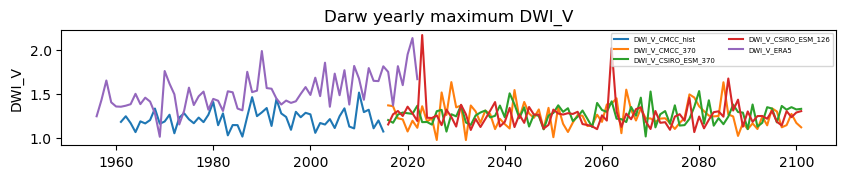

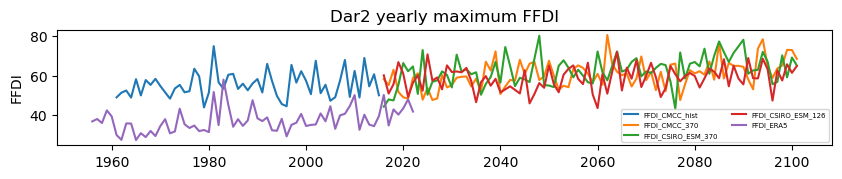

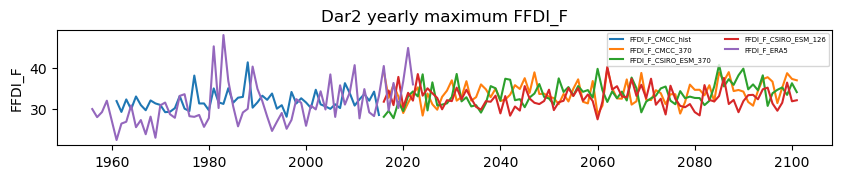

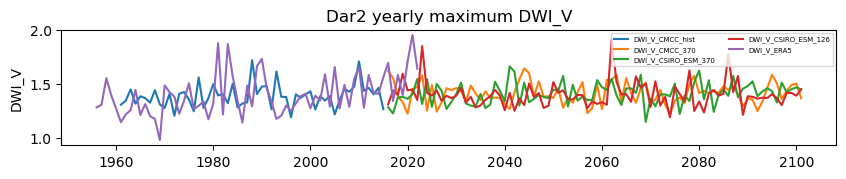

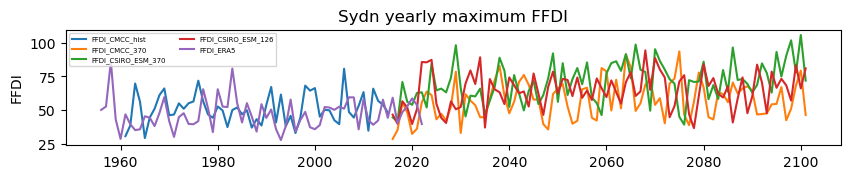

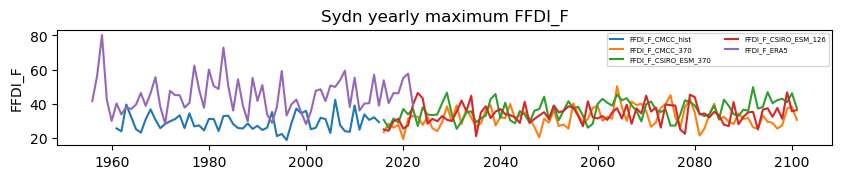

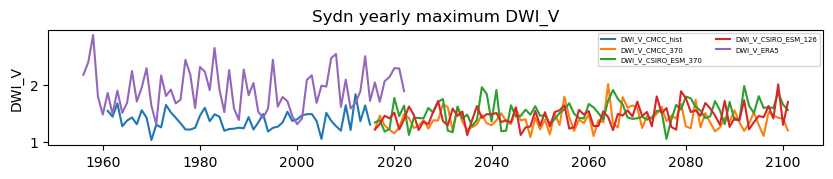

In [25]:
rcParams['figure.figsize'] = 10, 1.5
## Show each place on one plot

ts_places = [ts_melb,ts_adel,ts_darw,ts_dar2,ts_sydn]
for ts in ts_places:
    for metric in ['FFDI','FFDI_F','DWI_V',]:
        
        for name,da in ts.items():
            # only one metric at a time
            if not (metric in name):
                continue
            # unfortunately FFDI is a subset of FFDI_F
            if metric == 'FFDI':
                if 'FFDI_F_' in name:
                    continue
            yearly_max = da.resample('Y').quantile(1.0)
            x = yearly_max.index
            y = yearly_max.values
            #print(yearly_max)
            plt.plot_date(x,y,'-',label=name[5:])
        placename=name[:4]
                
        plt.title(placename+' yearly maximum '+metric)
        plt.ylabel(metric)
        plt.legend(ncol=2,fontsize=5)
        plt.show()
    
    #plt.title("FFDI")
    #plt.xlim([np.datetime64('1960-01-01'),np.datetime64('2101-01-01')])

## 95th pctl (5th worst day yearly)

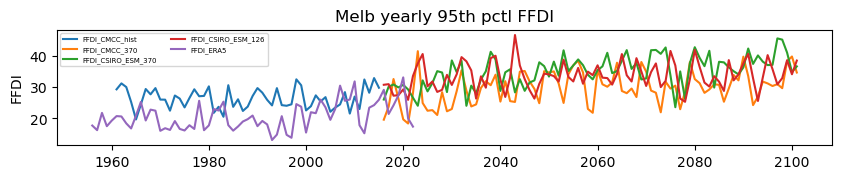

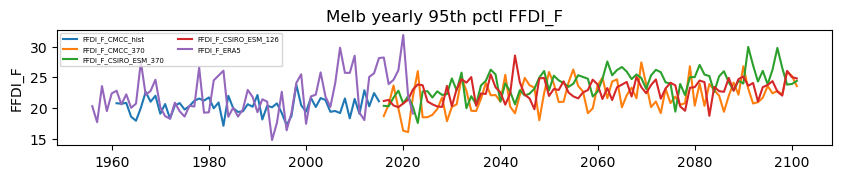

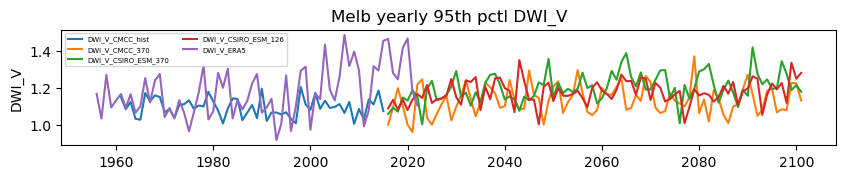

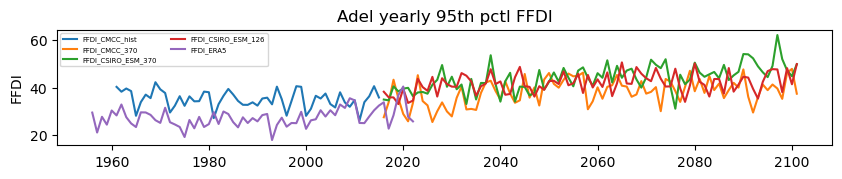

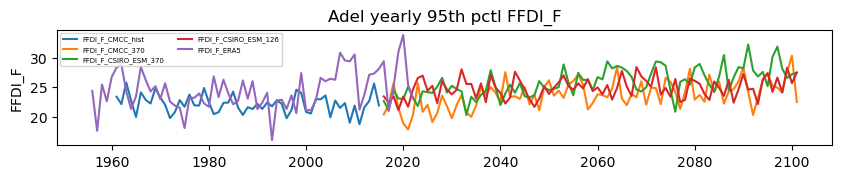

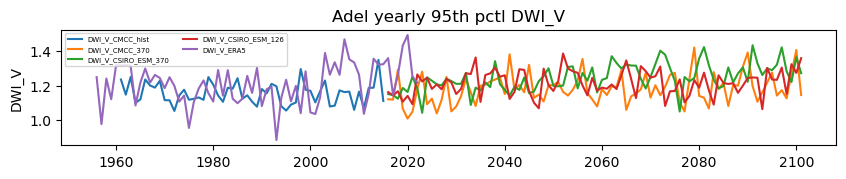

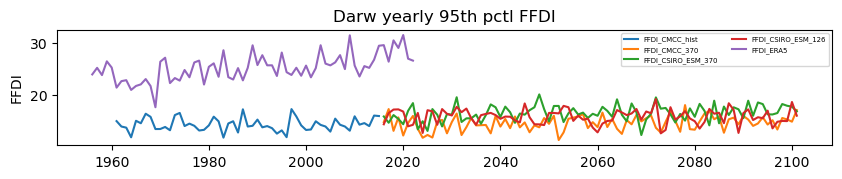

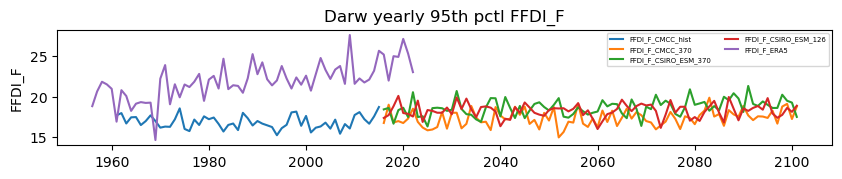

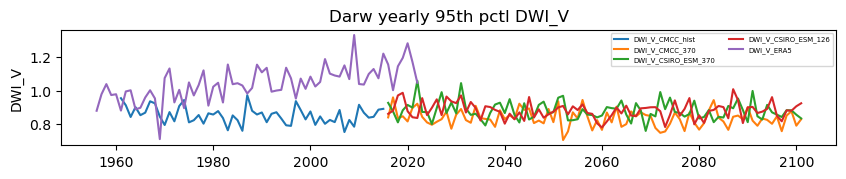

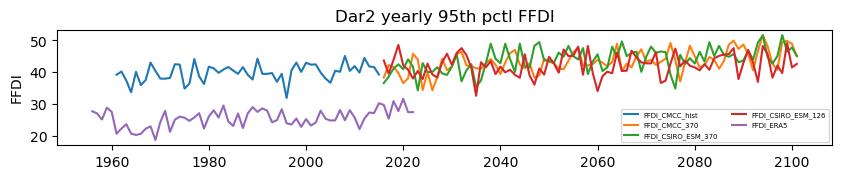

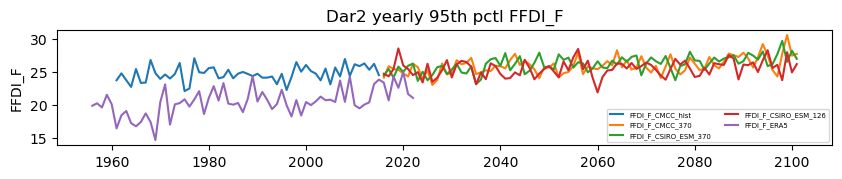

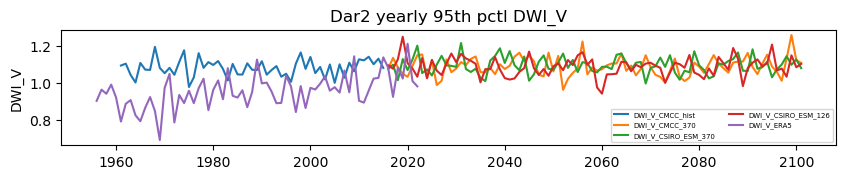

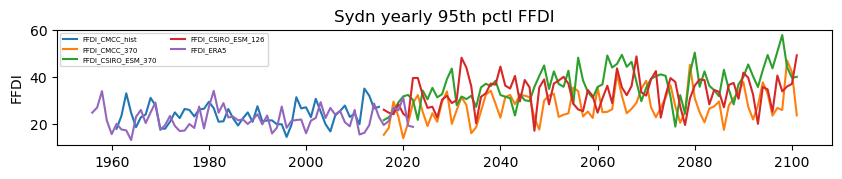

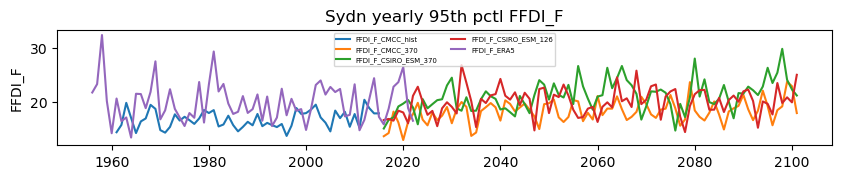

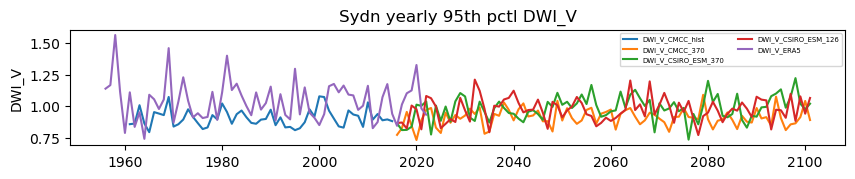

In [26]:

for ts in ts_places:
    for metric in ['FFDI','FFDI_F','DWI_V',]:
        
        for name,da in ts.items():
            # only one metric at a time
            if not (metric in name):
                continue
            # unfortunately FFDI is a subset of FFDI_F
            if metric == 'FFDI':
                if 'FFDI_F_' in name:
                    continue
            yearly_max = da.resample('Y').quantile(0.95)
            x = yearly_max.index
            y = yearly_max.values
            
            plt.plot_date(x,y,'-',label=name[5:])
        placename=name[:4]
                
        plt.title(placename+' yearly 95th pctl '+metric)
        plt.ylabel(metric)
        plt.legend(ncol=2,fontsize=5)
        plt.show()
    
    #plt.title("FFDI")
    #plt.xlim([np.datetime64('1960-01-01'),np.datetime64('2101-01-01')])

## Differences between FFDI and FFDIF

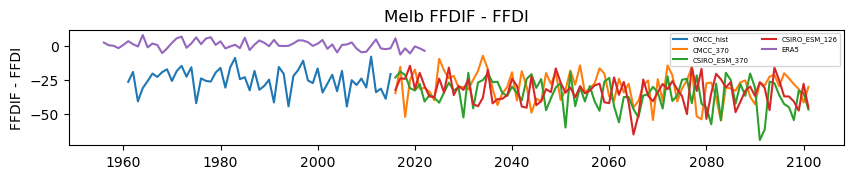

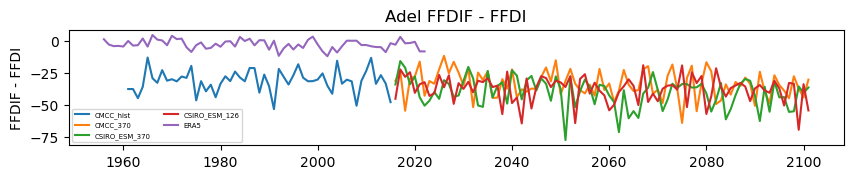

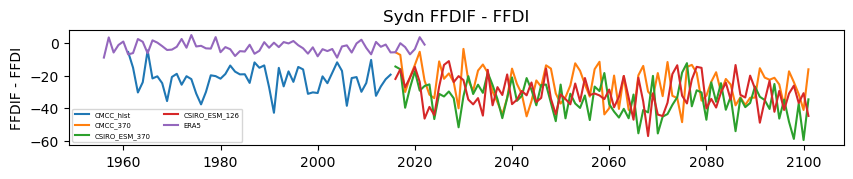

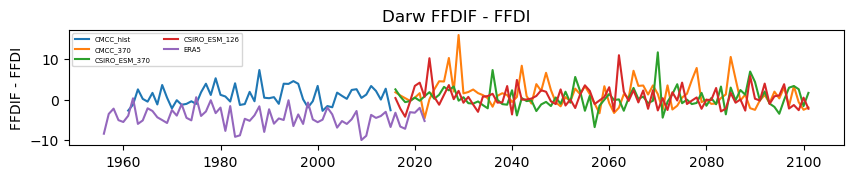

In [28]:
ts_places = [ts_melb,ts_adel,ts_sydn,ts_darw]
ts_names = ['Melb','Adel', 'Sydn','Darw']
diffs = {}
for ts,locname in zip(ts_places,ts_names):
    for key in ['_FFDI_CMCC_hist', '_FFDI_CMCC_370', '_FFDI_CSIRO_ESM_370', '_FFDI_CSIRO_ESM_126', '_FFDI_ERA5', ]:
        ffdiname = locname+key
        diffname = ffdiname[:4]+"_diff_"+ffdiname[10:]
        ffdifname = ffdiname[:9]+"_F"+ffdiname[9:]
        #print(diffname, ffdifname)
        ffdi = ts[ffdiname].resample('Y').quantile(1.0)
        ffdif = ts[ffdifname].resample('Y').quantile(1.0)
        diff = ffdif-ffdi
        diffs[diffname] = diff 

    for name,ts in diffs.items():
        
        x = ts.index
        y = ts.values
        plt.plot_date(x,y,'-',label=name[10:])
        
        plt.title("%s FFDIF - FFDI"%name[:4])
    plt.ylabel("FFDIF - FFDI")
    plt.legend(ncol=2,fontsize=5)
    plt.show()
    diffs={}
    #plt.title("FFDI")
    #plt.xlim([np.datetime64('1960-01-01'),np.datetime64('2101-01-01')])

# Analyse and find trend
1. simple linear regression of yearly maximums
2. change detection using ruptures library
    - https://forecastegy.com/posts/change-point-detection-time-series-python/
```
pip install --user ruptures
```

In [5]:
import ruptures as rpt

In [31]:
dir(rpt.Pelt())

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_seg',
 'cost',
 'fit',
 'fit_predict',
 'jump',
 'min_size',
 'n_samples',
 'predict']

In [16]:
ts_full = pd.concat([ts_melb['Melb_FFDI_CMCC_370'],ts_melb['Melb_FFDI_CMCC_hist']])


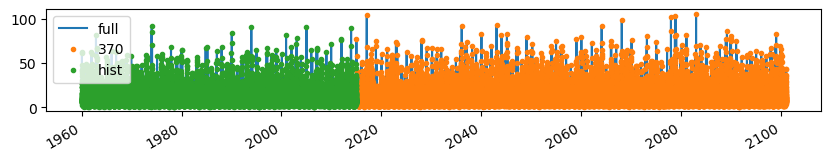

In [26]:
rcParams['figure.figsize'] = 10, 1.5
ts_full.plot(label='full')
ts_melb['Melb_FFDI_CMCC_370'].plot(style=['.'],label='370')
ts_melb['Melb_FFDI_CMCC_hist'].plot(style=['.'],label='hist')
plt.legend()

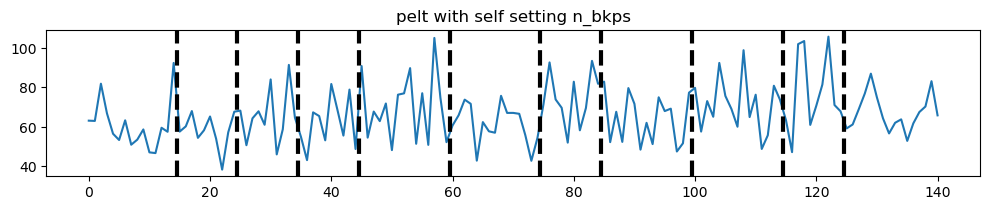

TypeError: Pelt.predict() got an unexpected keyword argument 'n_bkps'

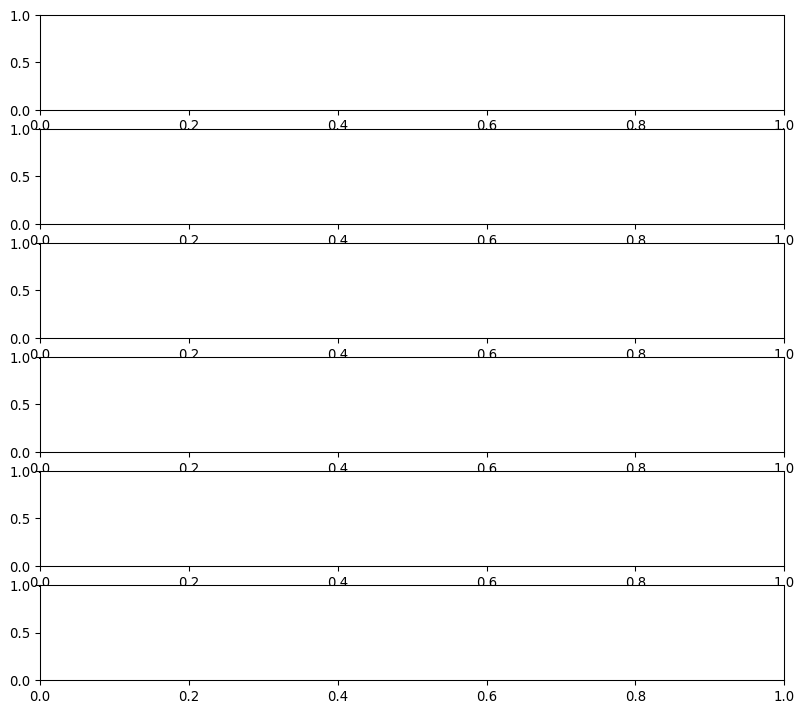

In [28]:
# Detect change points with PELT: Pruned Exact Linear Time
# 

# which TS are we looking at:
# cmcc has historical and 370 that can be combined
ts = ts_full.resample('Y').max()
data = ts.values.reshape(-1,1)

# 10 years minimum to detect 'change' in trend
algo = rpt.Pelt(model="l2", min_size=10)
algo.fit(data)
result = algo.predict(pen=1)
rpt.display(ts, [], result)
plt.title("pelt with self setting n_bkps")
plt.show()
## What about looping over with specified number of break points?
fig, ax = plt.subplots(6,1, figsize=(10, 9), dpi=96)
ax = ax.ravel()
for i, n_bkps in enumerate([1, 2, 3, 4, 5, 6]):
    result = algo.predict(n_bkps=n_bkps)
    ax.plot(ts)
    for bkp in result:
        ax[i].axvline(x=bkp, color='k', linestyle='--')
    ax[i].set_title(f"Dynp model with {n_bkps} breakpoints")

## Decomposition of season

In [94]:
import statsmodels.api as sm
import pandas as pd

Melb_FFDI_CMCC_hist has nulls?  False


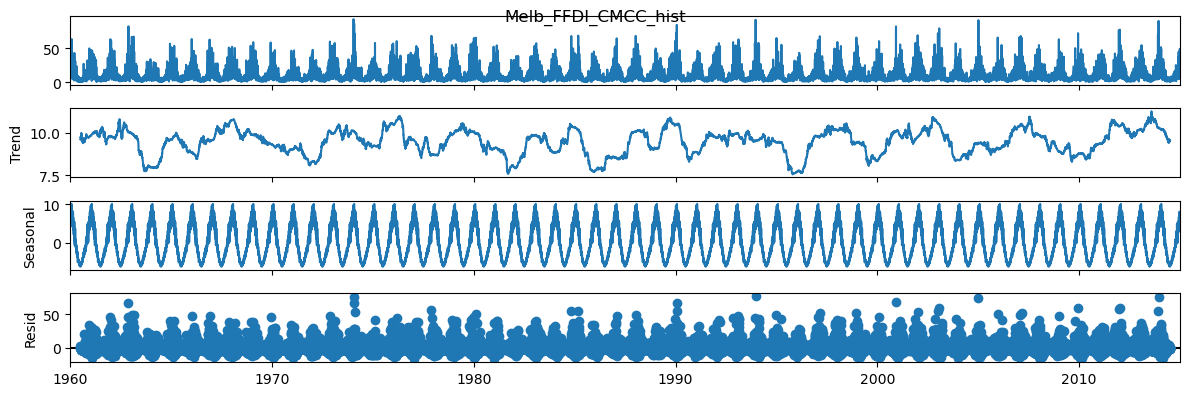

Melb_FFDI_CMCC_370 has nulls?  False


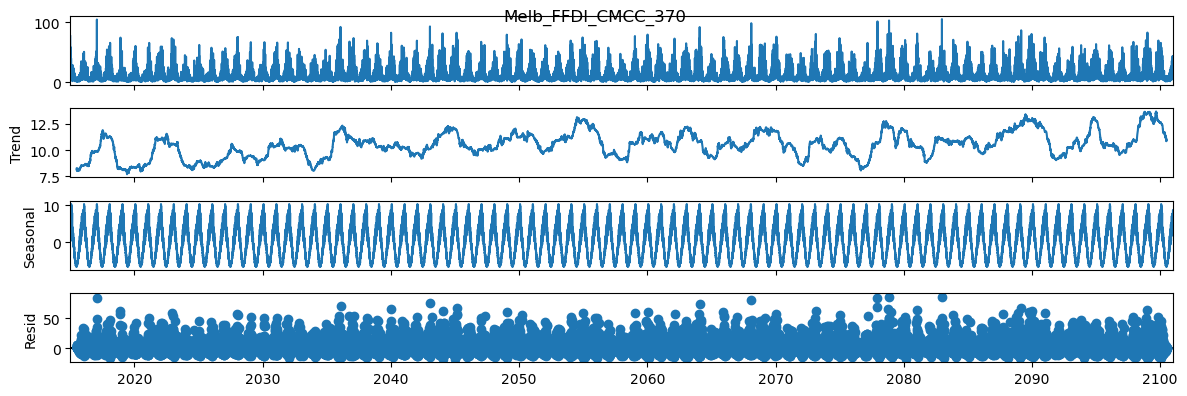

Melb_FFDI_CSIRO_ESM_370 has nulls?  True


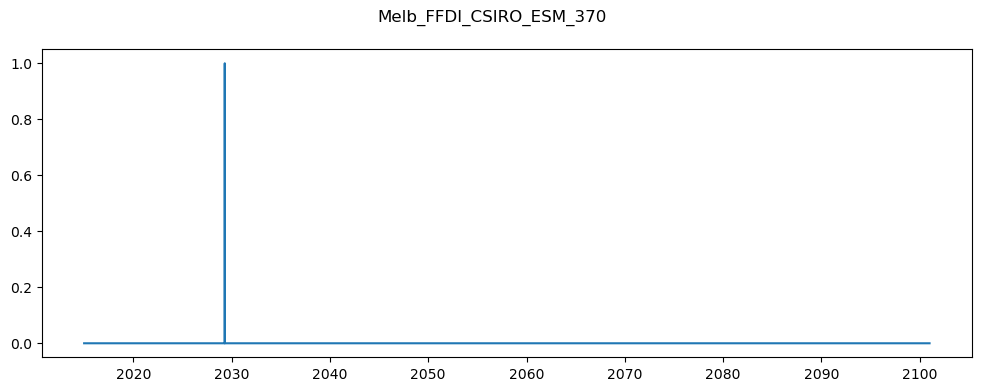

Melb_FFDI_CSIRO_ESM_126 has nulls?  True


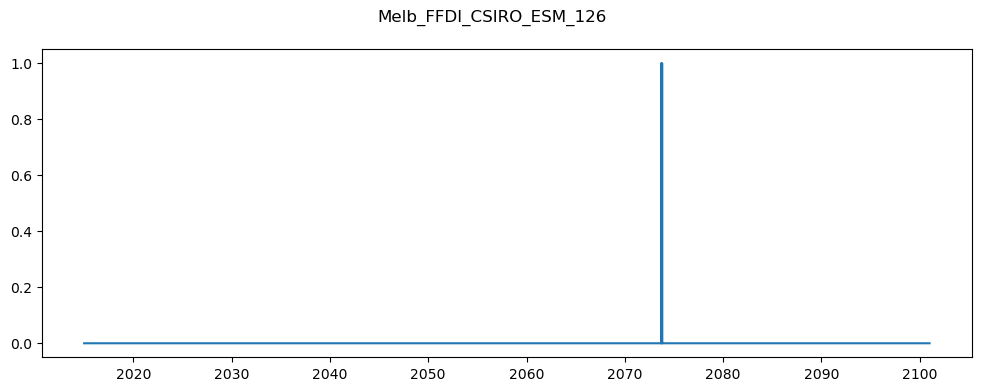

Melb_FFDI_ERA5 has nulls?  False


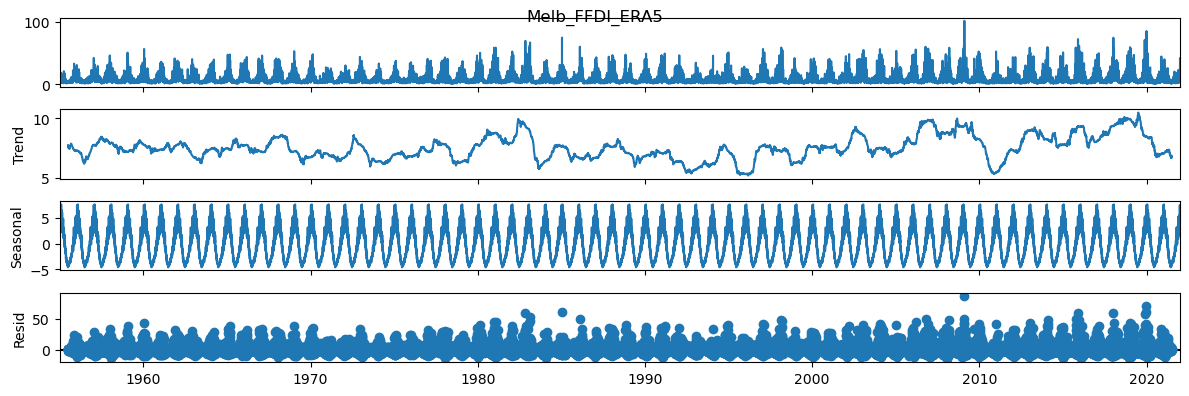

Adel_FFDI_CMCC_hist has nulls?  False


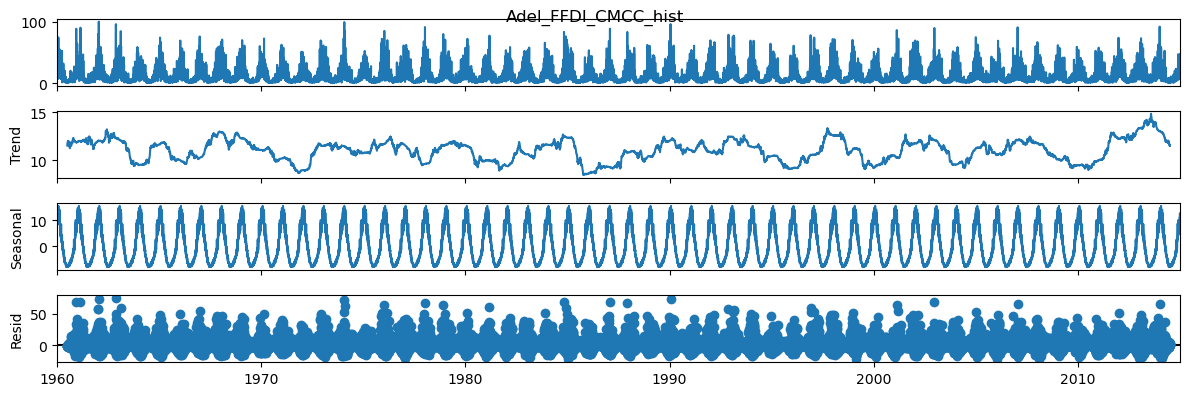

Adel_FFDI_CMCC_370 has nulls?  False


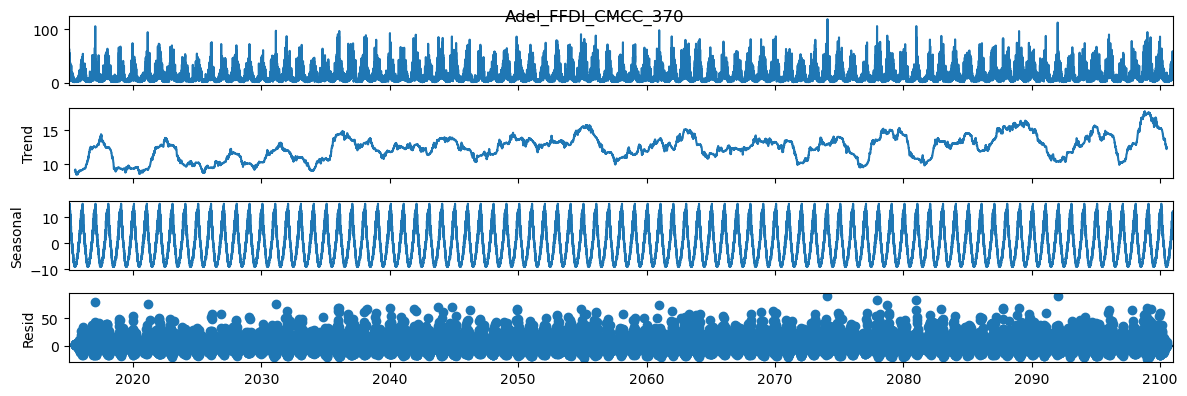

Adel_FFDI_CSIRO_ESM_370 has nulls?  True


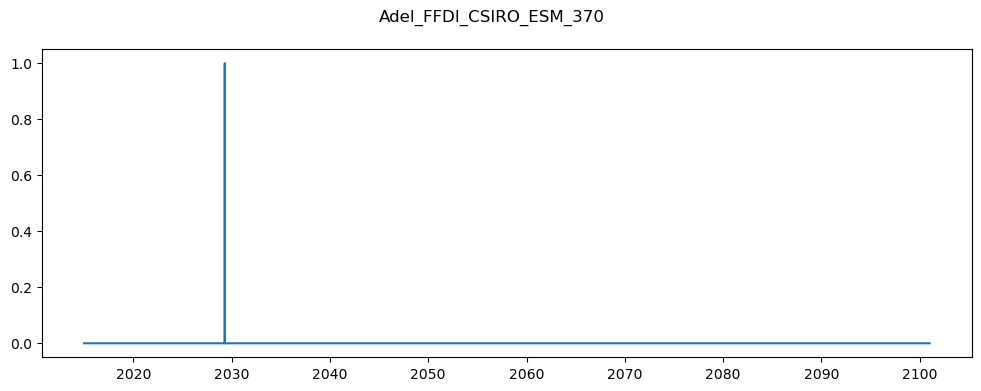

Adel_FFDI_CSIRO_ESM_126 has nulls?  True


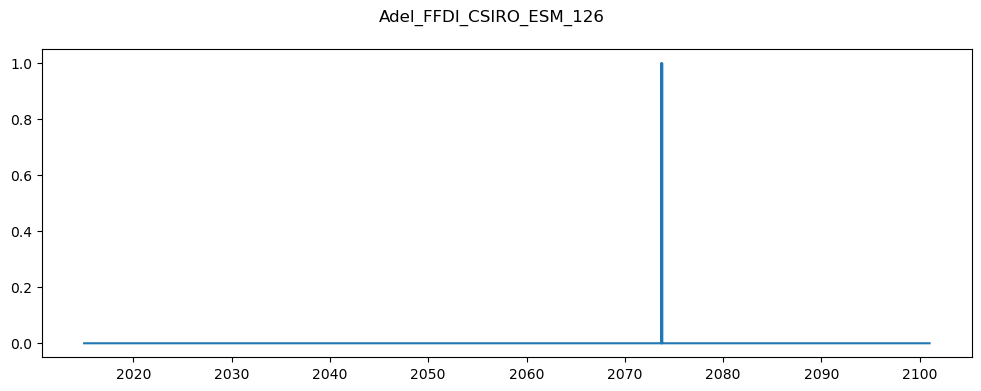

Adel_FFDI_ERA5 has nulls?  False


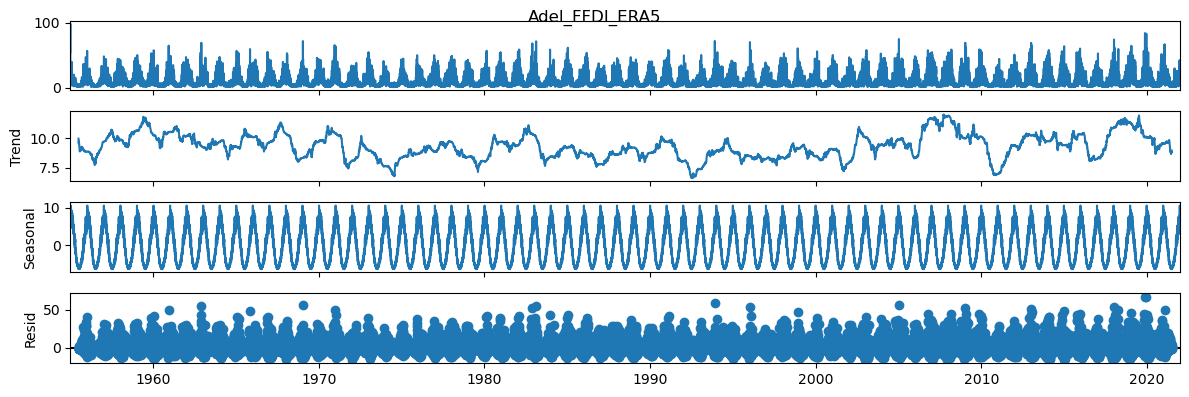

Sydn_FFDI_CMCC_hist has nulls?  False


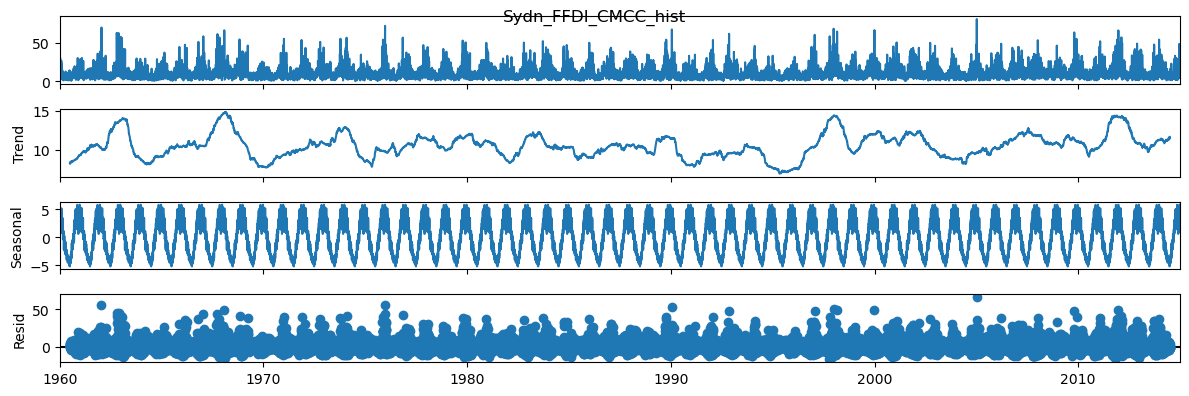

Sydn_FFDI_CMCC_370 has nulls?  False


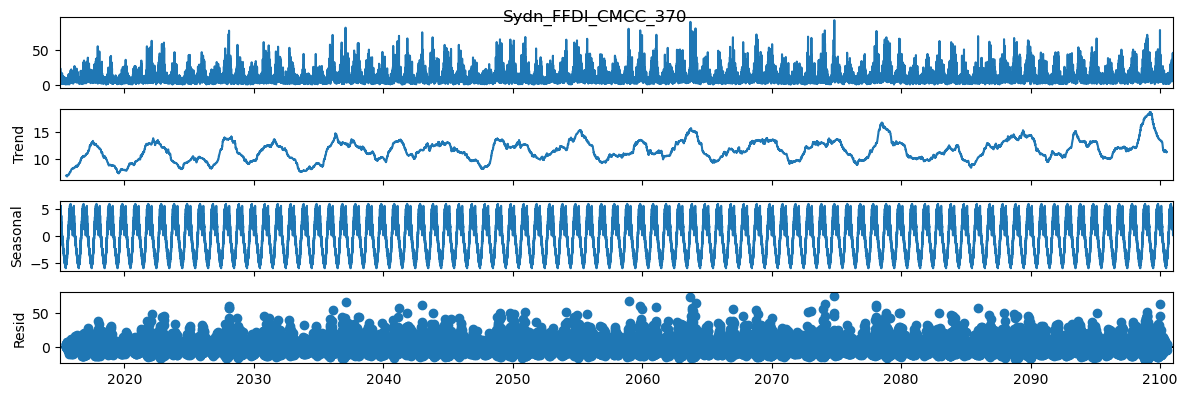

Sydn_FFDI_CSIRO_ESM_370 has nulls?  True


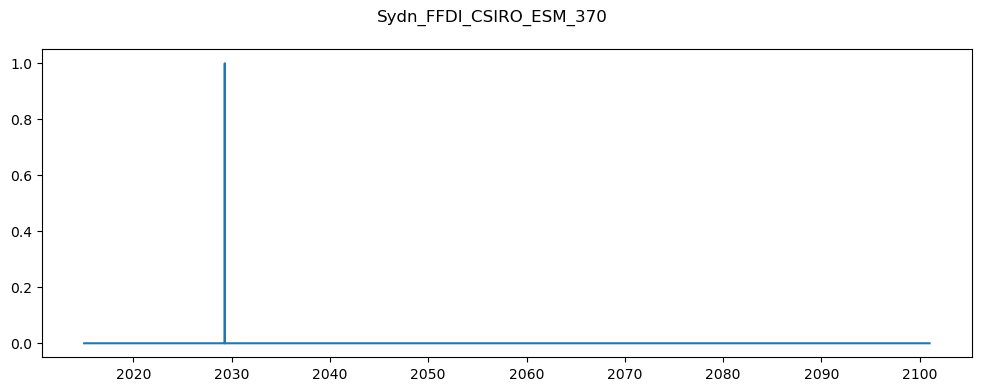

Sydn_FFDI_CSIRO_ESM_126 has nulls?  True


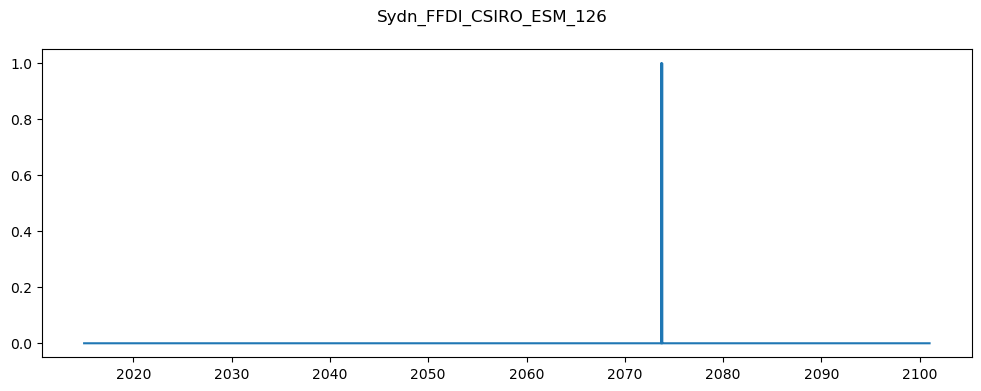

Sydn_FFDI_ERA5 has nulls?  False


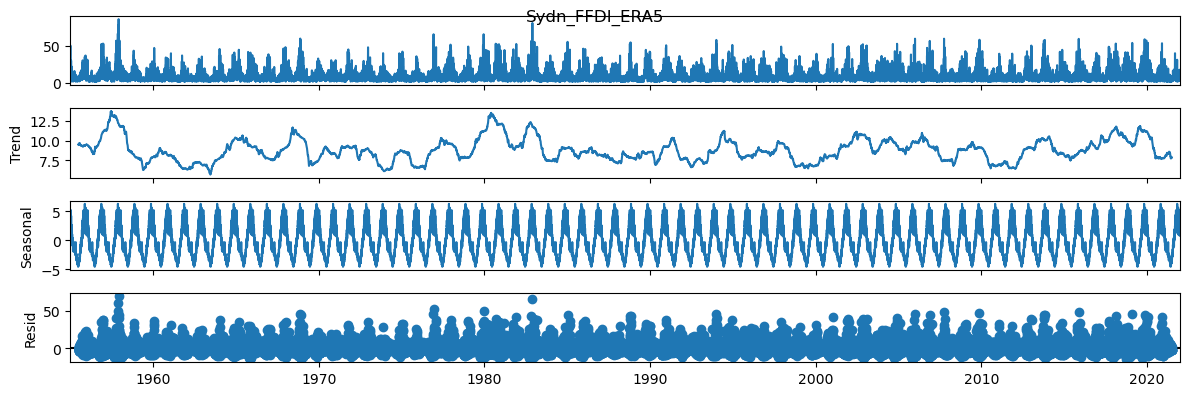

Darw_FFDI_CMCC_hist has nulls?  False


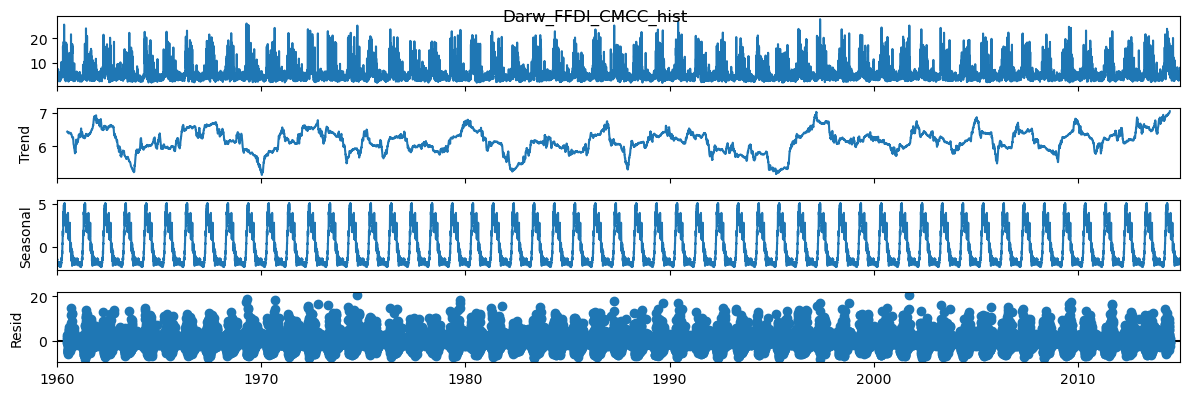

Darw_FFDI_CMCC_370 has nulls?  False


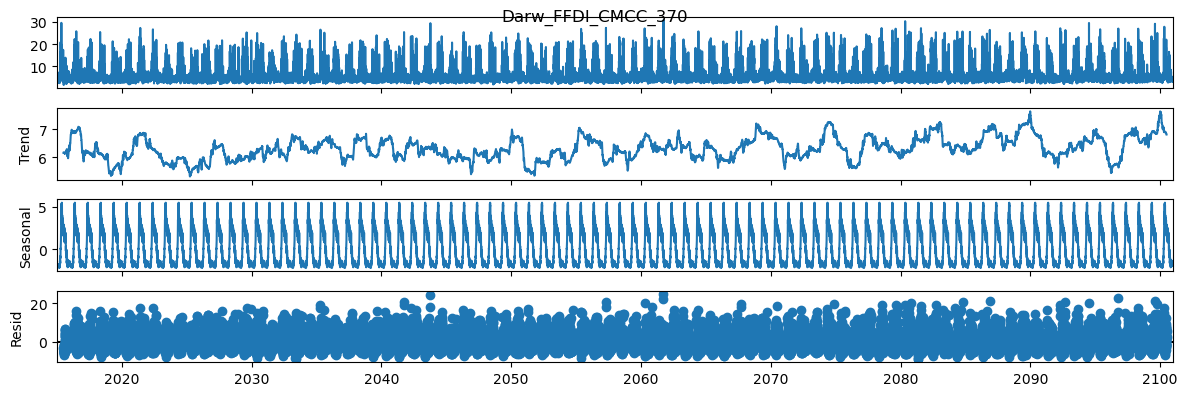

Darw_FFDI_CSIRO_ESM_370 has nulls?  True


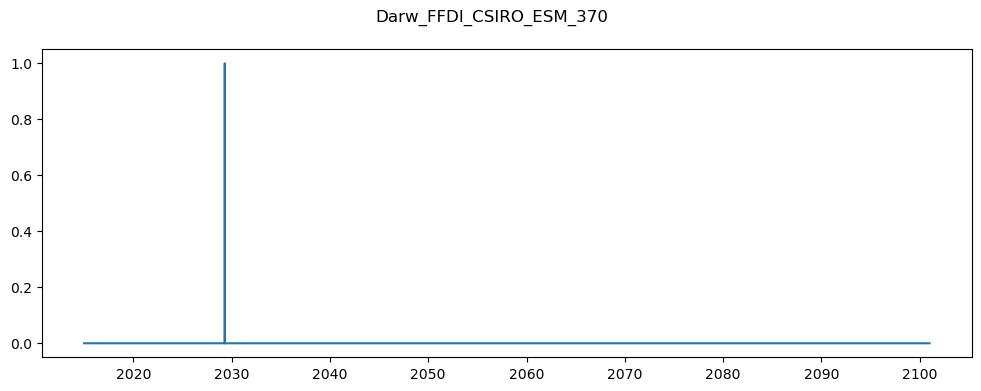

Darw_FFDI_CSIRO_ESM_126 has nulls?  True


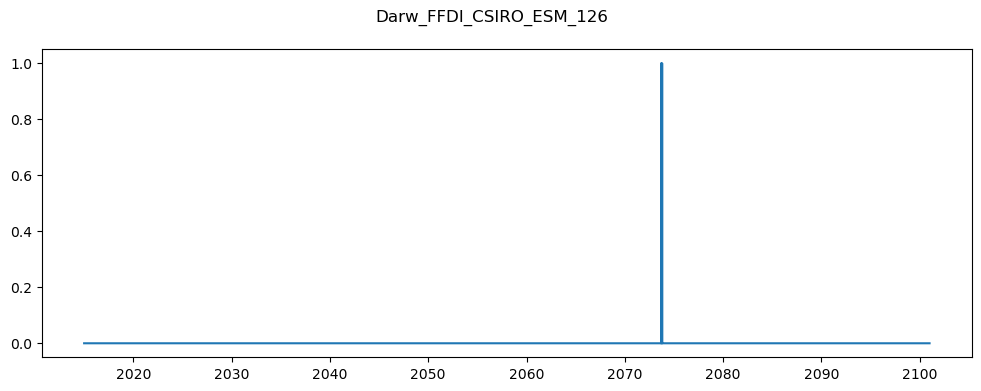

Darw_FFDI_ERA5 has nulls?  False


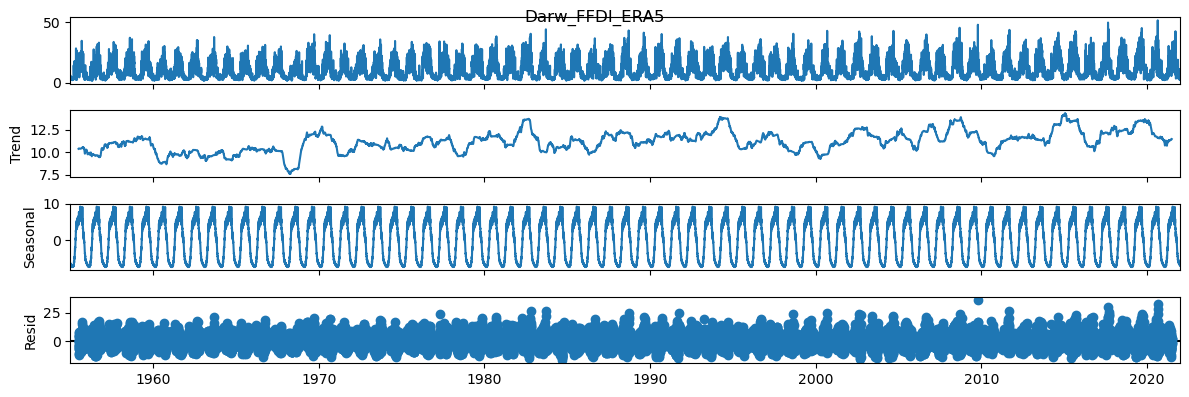

In [97]:
## Show each place on one plot
rcParams['figure.figsize'] = 12, 4
for varname,da in ts_places.items():
    da1=da.copy()
    if da.isnull().values.any():
        print(varname, "has %d nulls"%da.isnull().sum())
        da1=da
    else:
        decomposition = sm.tsa.seasonal_decompose(da, model='additive',period=365)
        fig = decomposition.plot()
    plt.suptitle(varname)
    plt.show()

    #assert False,"stop here"

    #plt.title(placename+' yearly 95th pctile')
    #plt.ylabel("FFDI")
    #plt.legend()
    #plt.show()
